<a href="https://colab.research.google.com/github/Dain777666/ESAA_25-2/blob/main/OB_WEEK16_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OB 시계열 연습문제**


AAPL(Apple Inc.)의 주가 데이터를 이용하여, 과거 60일의 종가 데이터를 입력으로 받아 다음 날의 주가를 예측하는 LSTM 모델을 구현하고 예측 결과를 시각화해봅시다.🚀

### 0. 필요 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# device 설정: 가능하면 GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. 데이터 다운로드 및 전처리

1-a. yfinance 라이브러리를 사용해 AAPL(Apple Inc.)의 주가 데이터를 2010년 1월 1일부터 2023년 1월 1일까지 다운로드하세요. 다운로드한 데이터에서 'Close' 컬럼만 선택하고, 결측치를 제거하세요.

힌트: yf.download(ticker, start, end) 함수를 사용합니다.


In [2]:
# 데이터 로드
ticker = 'AAPL'
data = yf.download(ticker, start="2010-01-01", end="2023-01-01")

# Close 칼럼만 선택
df = data[['Close']]

# 결측치 제거
df.dropna(inplace=True)

/tmp/ipython-input-496632516.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-496632516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


1-b. MinMaxScaler를 이용해 데이터를 0~1 범위로 정규화하세요.

In [3]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

### 2. 시퀀스 데이터 생성

정규화된 데이터를 바탕으로, 슬라이딩 윈도우 기법을 사용하여 지난 60일의 데이터를 입력 시퀀스로, 61번째 날의 데이터를 타깃으로 하는 시퀀스 데이터셋을 생성하세요.

힌트: for 루프를 활용해 인덱스를 이동하면서 각 시퀀스를 구성합니다. 시퀀스 데이터 생성 함수를 정의해 사용할 수 있습니다.

In [4]:
# 2. 시퀀스 데이터 생성 함수 (예: 지난 60일을 보고 다음 날 예측)
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(seq_length, len(data)):
        x = data[i-seq_length:i]  # 지난 seq_length일 데이터
        y = data[i]               # 다음 날 데이터 (타깃)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

### 3. 데이터셋 분할 및 Pytorch 텐서로 변환

3-a. 생성한 시퀀스 데이터를 학습용(80%)과 테스트용(20%)으로 분리하세요.

In [5]:
# 데이터셋을 학습용과 테스트용으로 분리 (80% 학습, 20% 테스트)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

3-b. 분리한 데이터를 PyTorch 텐서(torch.FloatTensor)로 변환하고, 타깃 데이터의 차원도 (batch_size, 1)로 맞추세요.

In [6]:
# 3. PyTorch 텐서로 변환
X_train = torch.from_numpy(X_train).type(torch.FloatTensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.FloatTensor).to(device)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor).to(device)

In [7]:
# 타깃 텐서의 차원 변경: (batch_size, 1)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

### 4. LSTM 모델 정의

PyTorch를 이용해 LSTM 모델을 구현하세요.
모델은 하나 이상의 LSTM 레이어와 최종 출력을 위한 Fully Connected(FC) 레이어로 구성되어야 합니다.
순전파(forward) 함수에서 초기 hidden state와 cell state를 올바르게 초기화하세요.

힌트: 교재 p.414 내용 참고

In [8]:
# 4. LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 출력층
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 초기 hidden state와 cell state (device에 맞게)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # LSTM 순전파: 모든 타임스텝의 출력과 최종 state 반환
        out, _ = self.lstm(x, (h0, c0))
        # 마지막 타임스텝의 출력을 사용
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTMModel().to(device)

### 5. 모델학습

5-a. 모델학습에 필요한 변수 값들(criterion, optimizer, num_epochs 등)을 정의하세요. (시간 상 epoch수는 30으로 하는 것을 추천합니다.)

In [9]:
# 손실함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

5-b. 정의한 LSTM 모델을 사용해 학습을 진행하세요.학습 과정에서 MSELoss를 손실함수로, Adam Optimizer를 최적화 도구로 사용하세요.

In [11]:
# 모델 학습
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [5/30], Loss: 0.011163
Epoch [10/30], Loss: 0.008573
Epoch [15/30], Loss: 0.008818
Epoch [20/30], Loss: 0.008743
Epoch [25/30], Loss: 0.008155
Epoch [30/30], Loss: 0.007985


### 6. 예측 결과 시각화

테스트 데이터를 활용하여 모델의 예측을 수행한 후, 예측 결과와 실제 주가를 비교하는 그래프를 작성하세요.
예측 결과와 실제 값은 정규화된 값이므로, scaler.inverse_transform을 사용해 원래 주가 값으로 복원해야 합니다.

힌트: 모델 예측 시 GPU를 사용했다면 .cpu().detach().numpy()를 통해 NumPy 배열로 변환하세요.


In [12]:
# 테스트 데이터에 대한 예측
model.eval()
predicted = model(X_test)
# 텐서를 numpy 배열로 변환 (GPU 사용 시 .cpu() 필요)
predicted = predicted.cpu().detach().numpy()
y_test_np = y_test.cpu().detach().numpy()

In [13]:
# 정규화 복원: 실제 주가로 변환
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test_np)

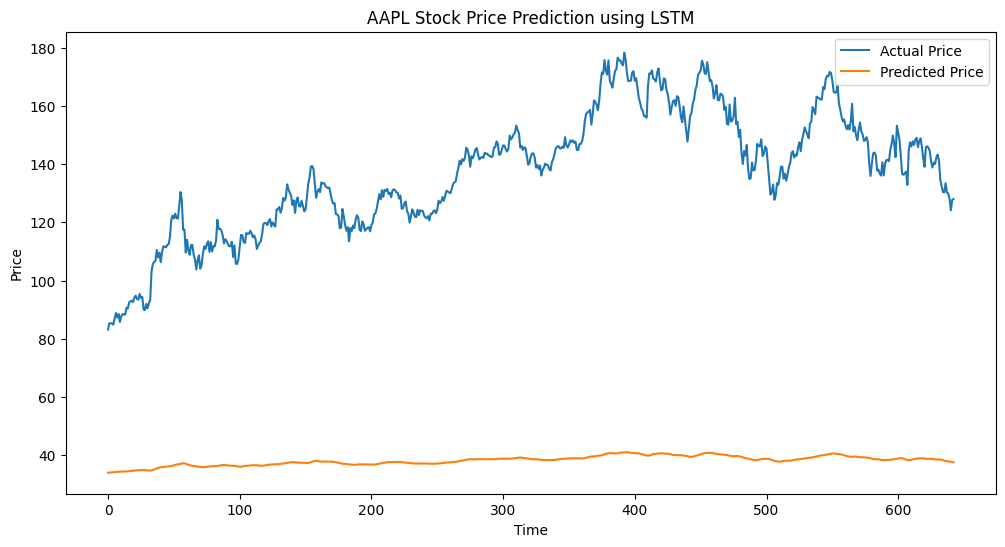

In [14]:
# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()